# Constants

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2' # only relevant to my own environment

I assume that you have downloaded MIDI dataset and uncompssed into `./midi_dataset/groove/` folder  
https://magenta.tensorflow.org/datasets/groove

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Training

In [3]:
import numpy as np

matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
NB_GENRES = len(GENRES)

print(GENRES_ID_USED)
print(NB_GENRES, GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)


[u'Old Skool' u'Trance' u'DnB' u'Basic' u'Downtempo' u'Jungle' u'House'
 u'Breakbeat' u'Garage' u'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
(7, [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno'])
(37950, 32, 9)
(37950,)


## Discriminator

In [4]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional
from keras.layers import Embedding, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order

# Conditioning label:
# Integer 0-NB_GENRES denoting the genre G should generate
label_input = Input(shape=(1,), dtype='int32')

# Embedding layer:
# Turns labels into dense vectors of size z_dim
# Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
label_embedding = Embedding(NB_GENRES, np.prod((len_seq, nb_notes)), input_length=1)(label_input)

# Flatten the embedding 3D tensor into 2D tensor with shape:(batch_size, 28*28*1)
label_embedding = Flatten()(label_embedding)

# Reshape label embeddings to have same dimensions as input images
label_embedding = Reshape((len_seq, nb_notes))(label_embedding)

# Concatenate images with corresponding label embeddings
concatenated = Concatenate(axis=-1)([drum_input, label_embedding])


x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(concatenated) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x = Reshape((1024,))(x)
# x = Dense(512)(x)
# x = LeakyReLU(alpha=0.01)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.01)(x)
output = Dense(1, activation='sigmoid')(x)

discriminator = Model([drum_input, label_input], output)
discriminator.summary()

optimizer = Adam(lr=0.00001) # higher leraning rate for D
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', 
                      metrics=['accuracy'])

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 288)       2016        input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 288)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
reshape_1 

## GENERATOR 

In [5]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

len_input = 100

z_input = Input(shape=(len_input,))  # tensorflow order

# Conditioning label
label_input = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(NB_GENRES, len_input, input_length=1)(label_input)
label_embedding = Flatten()(label_embedding)

# Element-wise product of the vectors z and the label embeddings
inputs2 = multiply([z_input, label_embedding])

# 
x = Dense(512)(inputs2)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)
x = Dropout(dropout_rate)(x)

x = LSTM(128, return_sequences=True, activation='tanh')(x) 
x = LSTM(128, return_sequences=True, activation='tanh')(x)
x = LSTM(9, return_sequences=True)(x)
note_out = LeakyReLU()(x)

generator = Model([z_input, label_input], note_out)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       700         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

## ADVERSARIAL MODEL 

In [6]:

from keras.models import Sequential


# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
label_input = Input(shape=(1,), dtype='int32')
img_gan = generator([z_input, label_input])

# training is disable for discriminator in adversarial model
discriminator.trainable = False 

# define output
prediction_gan = discriminator([img_gan, label_input])

# define combined GAN model
gan = Model([z_input, label_input], prediction_gan)
optimizer = Adam(lr=0.001)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 9)        802852      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            605281      model_2[1][0]                    
          

## Training

In [7]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 0.50, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

In [8]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir = "/tmp/tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
cmd = "tensorboard --logdir=" + logdir
print cmd

configure(logdir, flush_secs=5)

tensorboard --logdir=/tmp/tf_logs/20190729-162646/


In [9]:
gan.load_weights("./tmp/c_gan-epoch-044-0.89933.h5")
discriminator.load_weights("./tmp/c_discriminator-epoch-044-0.30924.h5")
generator.load_weights("./tmp/c_generator-epoch-044-0.89933.h5")

/home/nao/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


('epoch', 45, 0)
('d_loss', 0.3723007142543793, 'a_loss', 0.6965815)
('d_accuracy', 0.46484375)
(array([[4]]), u'Breakbeat')


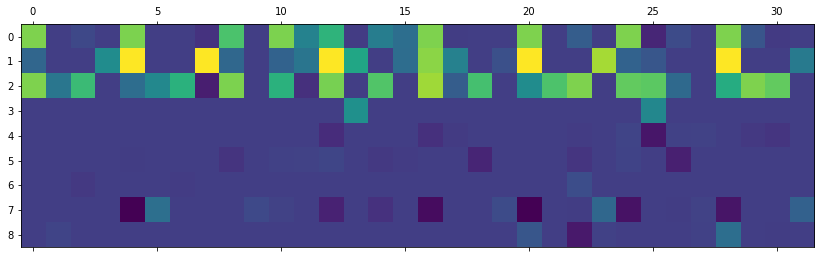



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 100)
('d_loss', 0.34335993230342865, 'a_loss', 0.7012941)
('d_accuracy', 0.45703125)
(array([[6]]), u'Techno')


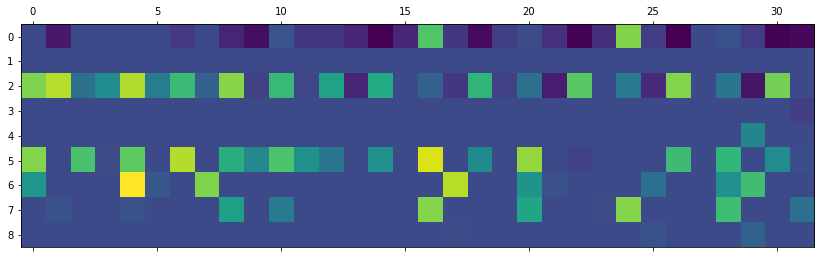



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 200)
('d_loss', 0.3490629941225052, 'a_loss', 1.1475179)
('d_accuracy', 0.46875)
(array([[1]]), u'DnB')


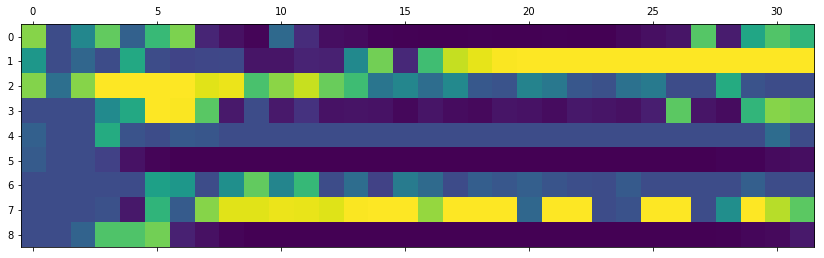



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 300)
('d_loss', 0.3761145994067192, 'a_loss', 0.5931063)
('d_accuracy', 0.4609375)
(array([[1]]), u'DnB')


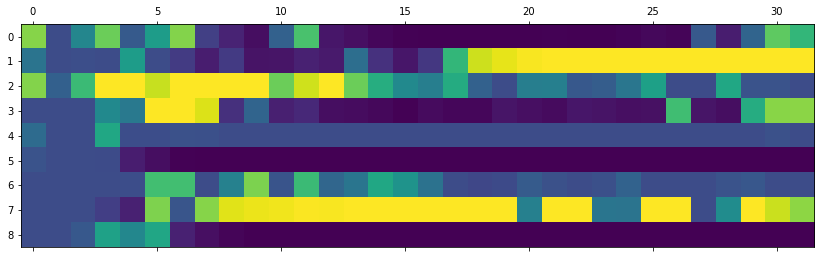



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 400)
('d_loss', 0.3665568381547928, 'a_loss', 0.8701931)
('d_accuracy', 0.46484375)
(array([[6]]), u'Techno')


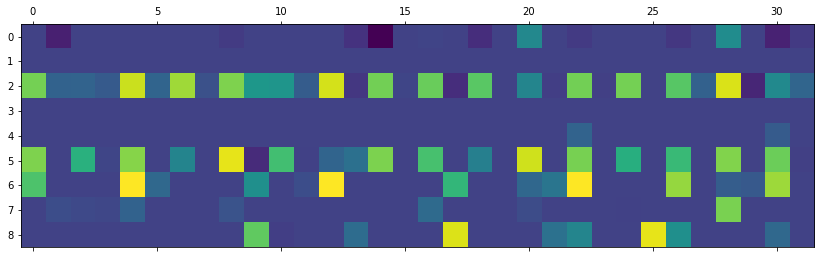



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 500)
('d_loss', 0.34642502665519714, 'a_loss', 1.3908304)
('d_accuracy', 0.47265625)
(array([[1]]), u'DnB')


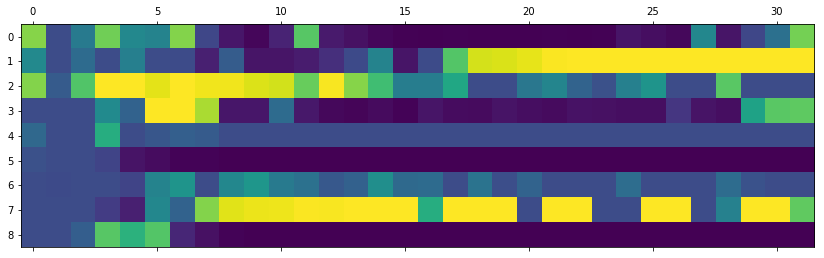



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 600)
('d_loss', 0.3444605618715286, 'a_loss', 0.8990803)
('d_accuracy', 0.4453125)
(array([[1]]), u'DnB')


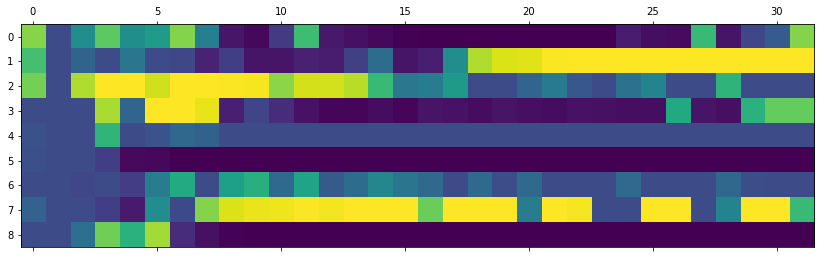



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 700)
('d_loss', 0.36671749502420425, 'a_loss', 1.009875)
('d_accuracy', 0.45703125)
(array([[4]]), u'Breakbeat')


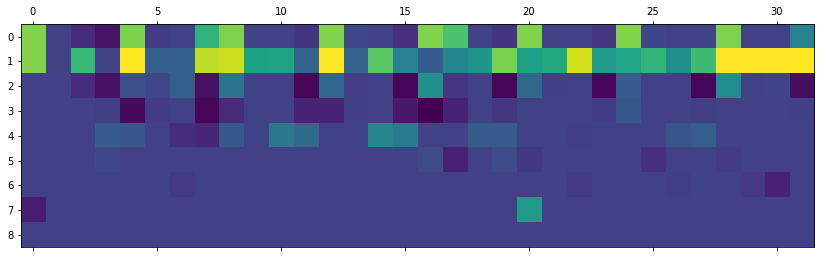



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 800)
('d_loss', 0.3431885689496994, 'a_loss', 0.8552303)
('d_accuracy', 0.4765625)
(array([[5]]), u'Garage')


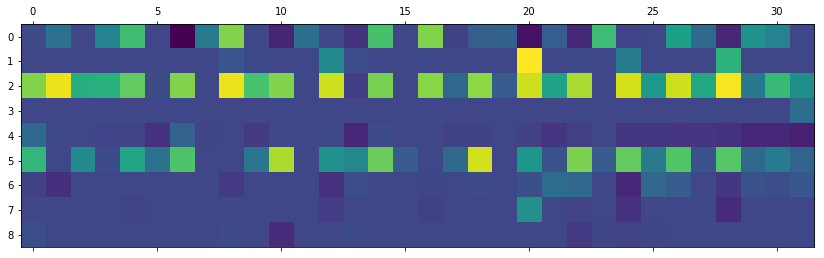



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 900)
('d_loss', 0.3118116408586502, 'a_loss', 0.561273)
('d_accuracy', 0.47265625)
(array([[5]]), u'Garage')


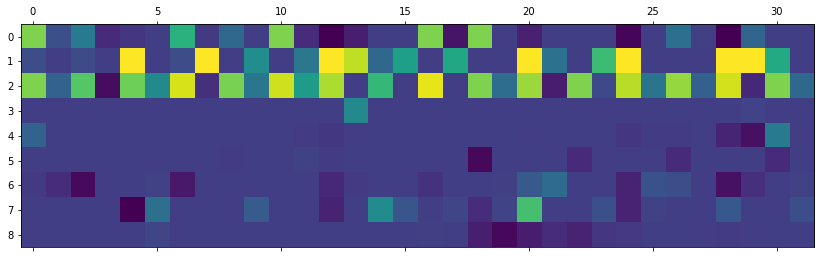



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 1000)
('d_loss', 0.3643213361501694, 'a_loss', 1.0528494)
('d_accuracy', 0.47265625)
(array([[2]]), u'Jungle')


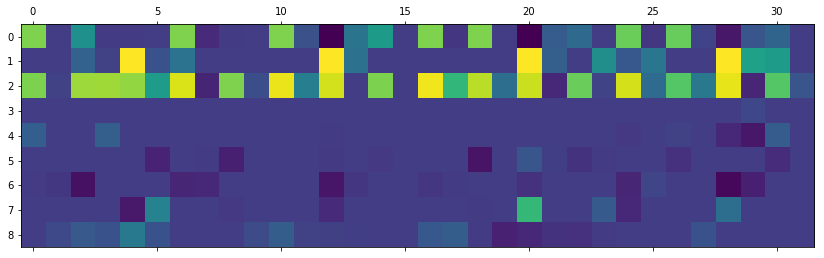



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 45, 1100)
('d_loss', 0.3528394177556038, 'a_loss', 1.2173235)
('d_accuracy', 0.47265625)
(array([[1]]), u'DnB')


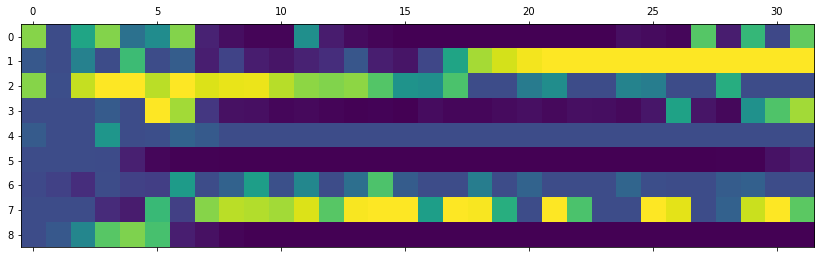



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 0)
('d_loss', 0.34489013999700546, 'a_loss', 0.6051409)
('d_accuracy', 0.47265625)
(array([[1]]), u'DnB')


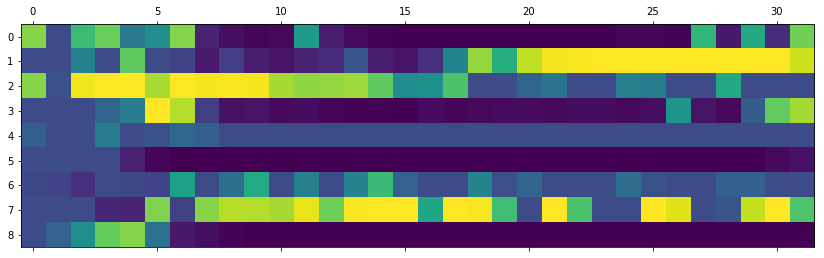



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 100)
('d_loss', 0.39555657655000687, 'a_loss', 0.87277114)
('d_accuracy', 0.46484375)
(array([[2]]), u'Jungle')


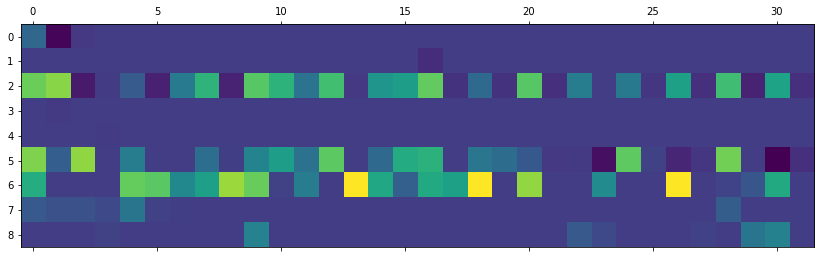



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 200)
('d_loss', 0.3551424965262413, 'a_loss', 0.46951288)
('d_accuracy', 0.44921875)
(array([[2]]), u'Jungle')


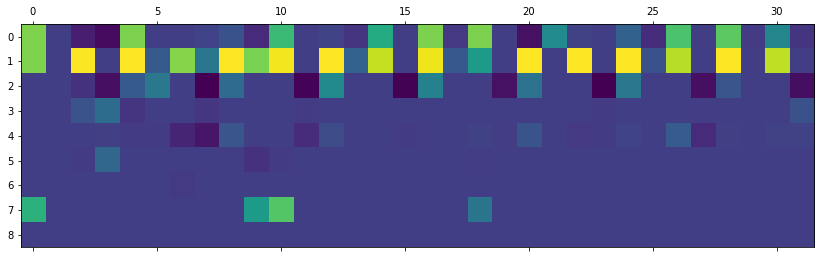



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 300)
('d_loss', 0.3429674804210663, 'a_loss', 0.8841949)
('d_accuracy', 0.4609375)
(array([[0]]), u'Old Skool')


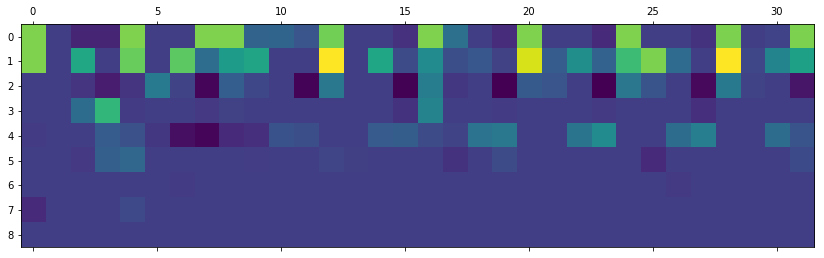



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 400)
('d_loss', 0.30554021894931793, 'a_loss', 0.8533908)
('d_accuracy', 0.4765625)
(array([[0]]), u'Old Skool')


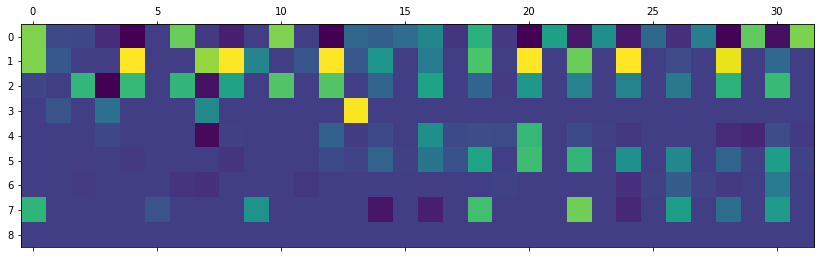



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 500)
('d_loss', 0.3219612091779709, 'a_loss', 1.3161179)
('d_accuracy', 0.47265625)
(array([[2]]), u'Jungle')


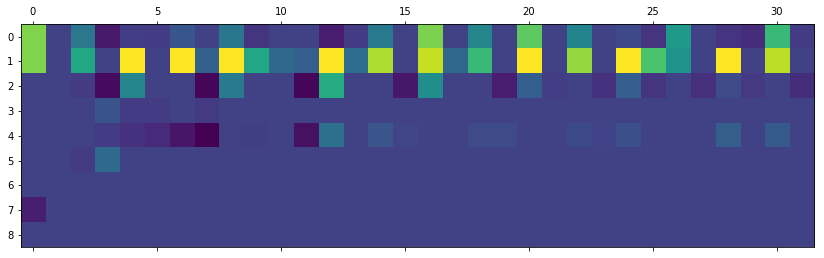



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 600)
('d_loss', 0.329746350646019, 'a_loss', 0.8091928)
('d_accuracy', 0.4765625)
(array([[0]]), u'Old Skool')


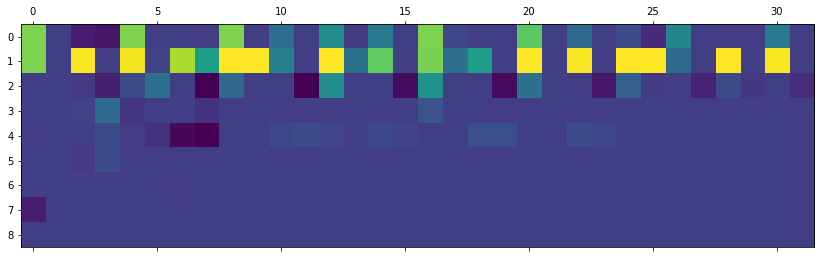



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 700)
('d_loss', 0.3589363619685173, 'a_loss', 1.0718)
('d_accuracy', 0.4765625)
(array([[1]]), u'DnB')


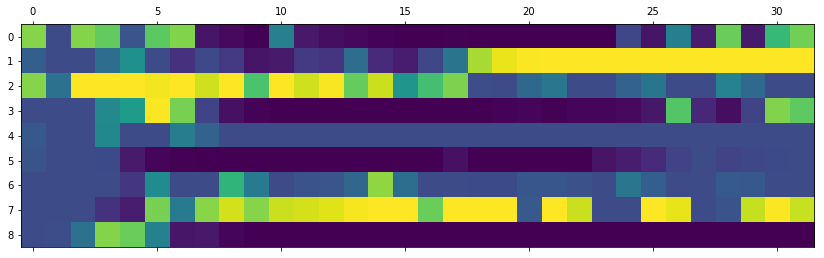



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 800)
('d_loss', 0.367249995470047, 'a_loss', 0.97946095)
('d_accuracy', 0.45703125)
(array([[0]]), u'Old Skool')


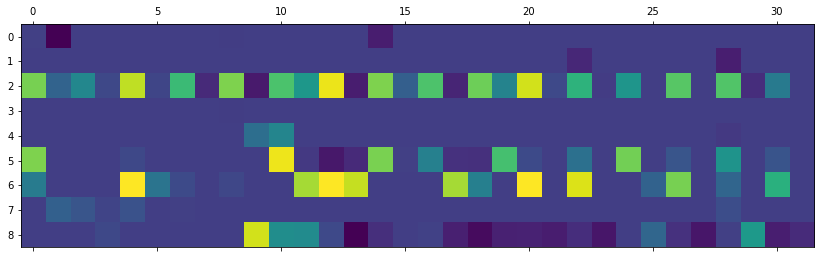



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 900)
('d_loss', 0.3801102563738823, 'a_loss', 0.77700245)
('d_accuracy', 0.47265625)
(array([[6]]), u'Techno')


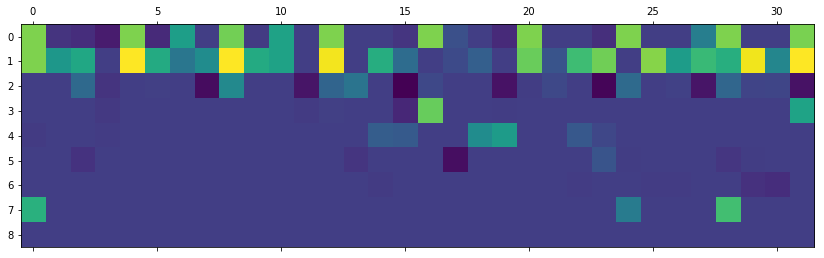



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 1000)
('d_loss', 0.3848847597837448, 'a_loss', 0.931085)
('d_accuracy', 0.4453125)
(array([[4]]), u'Breakbeat')


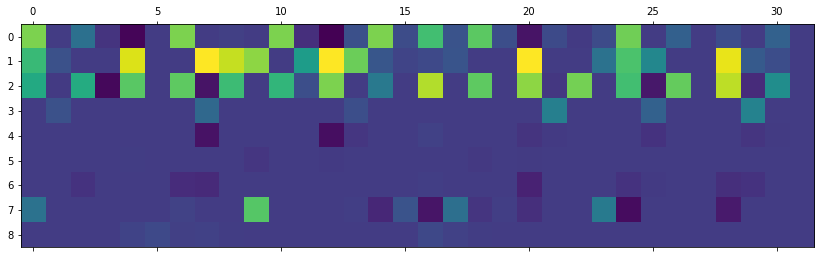



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 46, 1100)
('d_loss', 0.3316314369440079, 'a_loss', 0.9348824)
('d_accuracy', 0.47265625)
(array([[0]]), u'Old Skool')


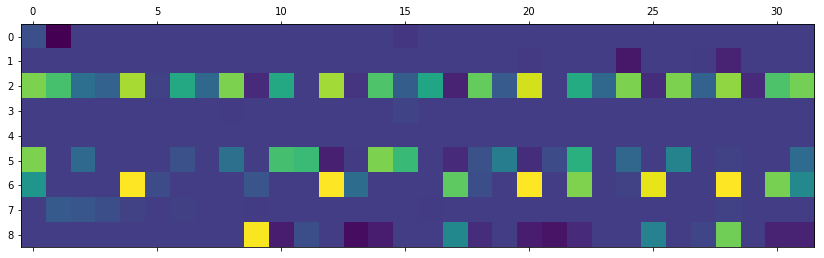



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 0)
('d_loss', 0.3859250843524933, 'a_loss', 0.9419912)
('d_accuracy', 0.45703125)
(array([[1]]), u'DnB')


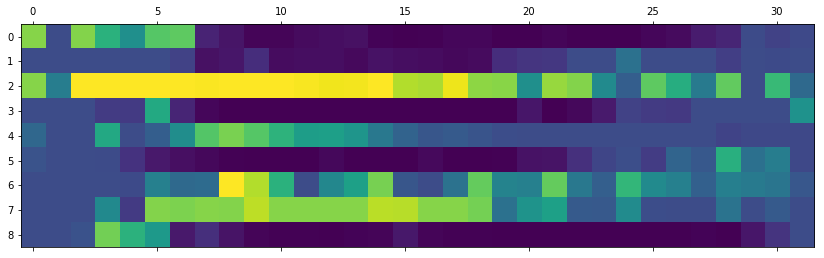



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 100)
('d_loss', 0.3165268898010254, 'a_loss', 1.0555851)
('d_accuracy', 0.45703125)
(array([[3]]), u'House')


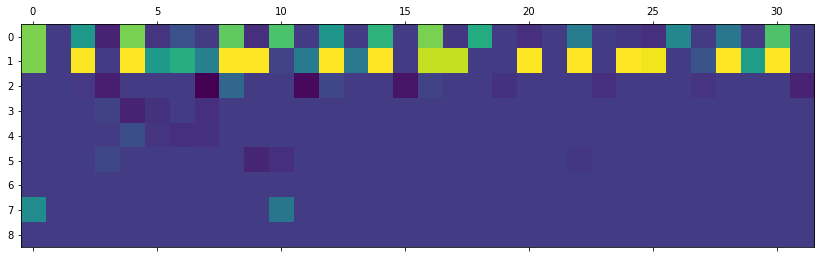



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 200)
('d_loss', 0.3294692859053612, 'a_loss', 0.7390249)
('d_accuracy', 0.48046875)
(array([[4]]), u'Breakbeat')


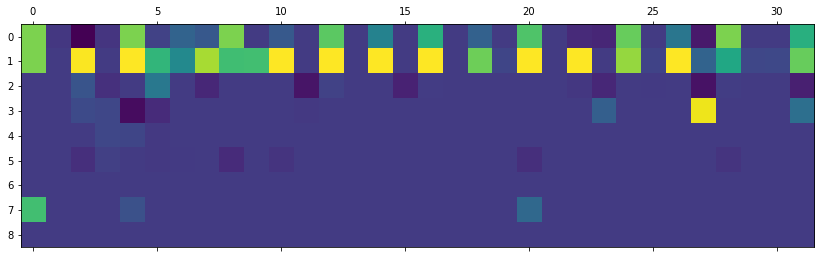



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 300)
('d_loss', 0.379651702940464, 'a_loss', 1.0984056)
('d_accuracy', 0.46484375)
(array([[1]]), u'DnB')


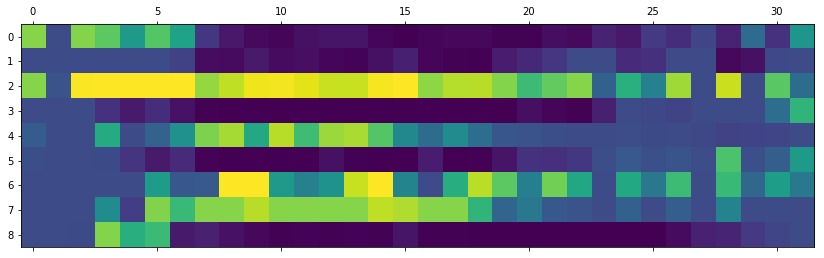



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 400)
('d_loss', 0.3335683271288872, 'a_loss', 0.75210166)
('d_accuracy', 0.45703125)
(array([[0]]), u'Old Skool')


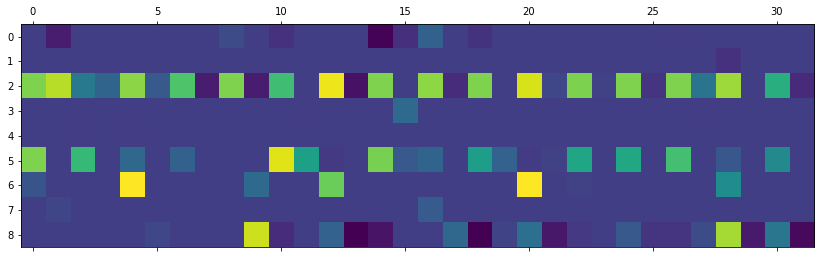



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 500)
('d_loss', 0.3346782401204109, 'a_loss', 0.656767)
('d_accuracy', 0.48828125)
(array([[1]]), u'DnB')


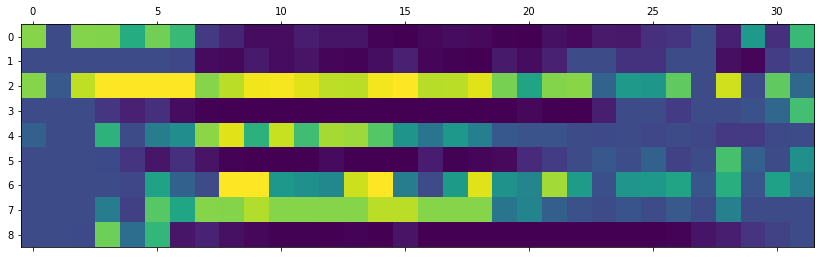



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 600)
('d_loss', 0.40459495782852173, 'a_loss', 0.7837654)
('d_accuracy', 0.453125)
(array([[3]]), u'House')


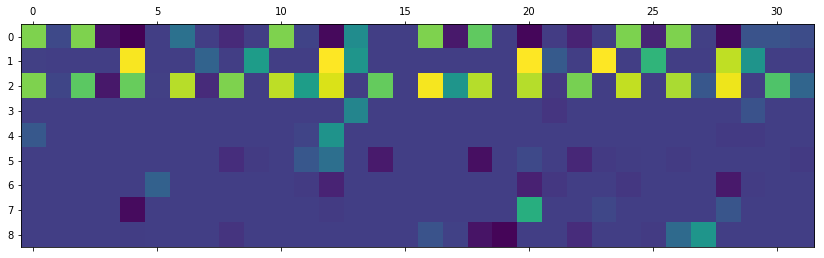



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 700)
('d_loss', 0.3811049088835716, 'a_loss', 0.8926027)
('d_accuracy', 0.47265625)
(array([[3]]), u'House')


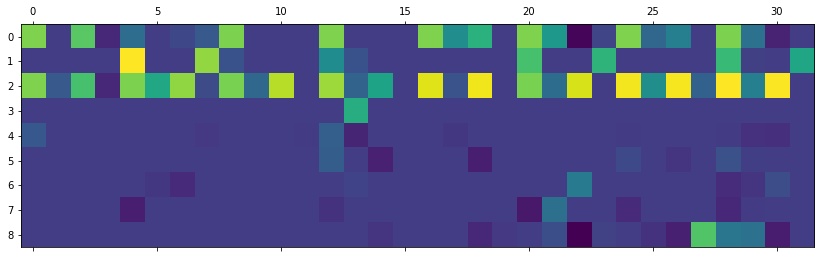



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 800)
('d_loss', 0.37692616879940033, 'a_loss', 1.2530227)
('d_accuracy', 0.453125)
(array([[2]]), u'Jungle')


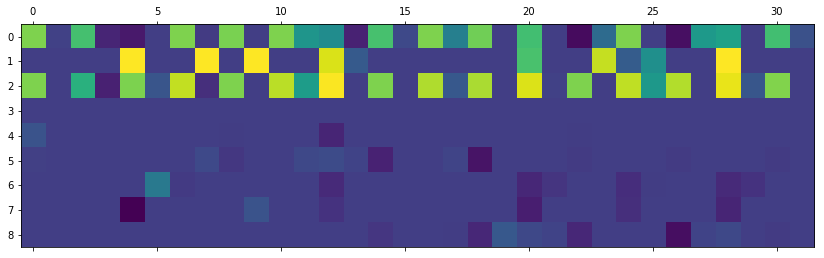



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 900)
('d_loss', 0.3876657336950302, 'a_loss', 0.9879885)
('d_accuracy', 0.4453125)
(array([[4]]), u'Breakbeat')


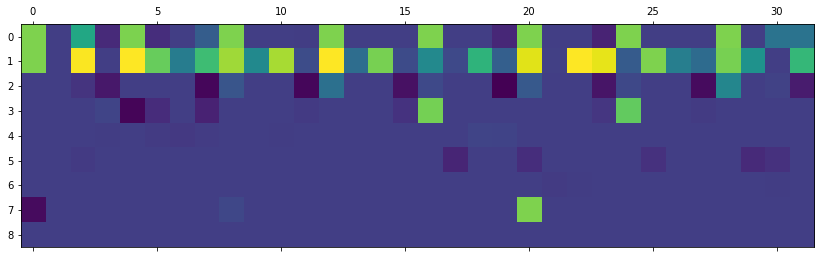



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 1000)
('d_loss', 0.3723274916410446, 'a_loss', 1.0454184)
('d_accuracy', 0.46484375)
(array([[3]]), u'House')


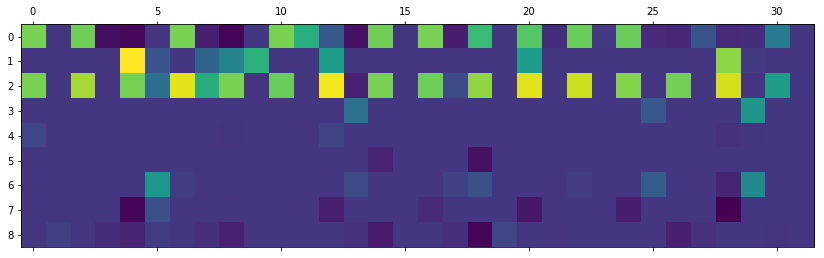



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 47, 1100)
('d_loss', 0.39246104657649994, 'a_loss', 0.72027224)
('d_accuracy', 0.45703125)
(array([[5]]), u'Garage')


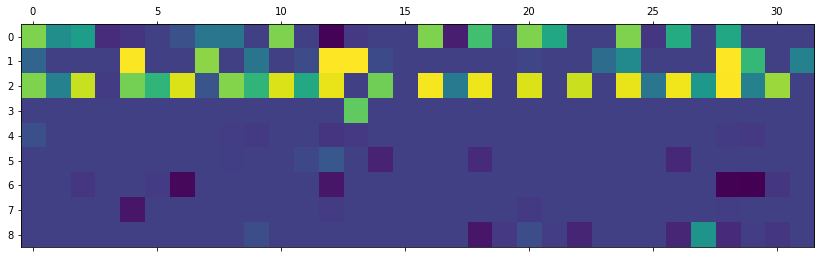



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 0)
('d_loss', 0.30114660412073135, 'a_loss', 1.0821551)
('d_accuracy', 0.5)
(array([[0]]), u'Old Skool')


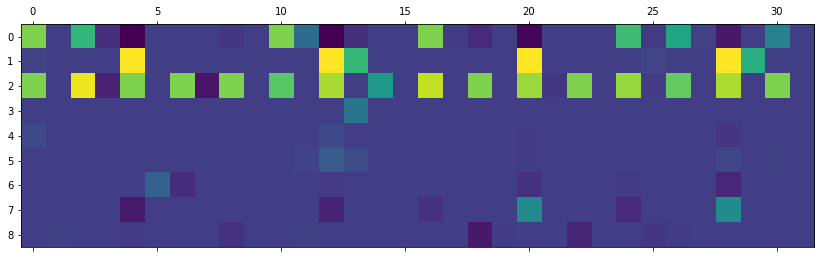



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 100)
('d_loss', 0.3311842158436775, 'a_loss', 0.9624505)
('d_accuracy', 0.4765625)
(array([[0]]), u'Old Skool')


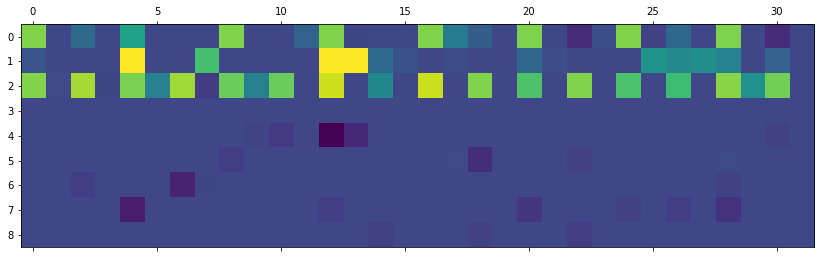



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 200)
('d_loss', 0.3641454428434372, 'a_loss', 0.7284959)
('d_accuracy', 0.46875)
(array([[5]]), u'Garage')


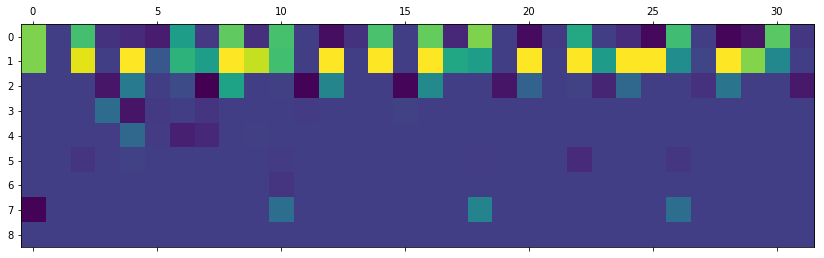



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 300)
('d_loss', 0.37613917142152786, 'a_loss', 0.9381032)
('d_accuracy', 0.45703125)
(array([[5]]), u'Garage')


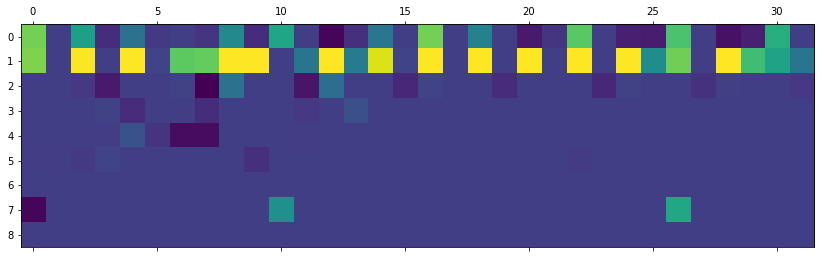



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 400)
('d_loss', 0.3577665090560913, 'a_loss', 0.83091587)
('d_accuracy', 0.44921875)
(array([[2]]), u'Jungle')


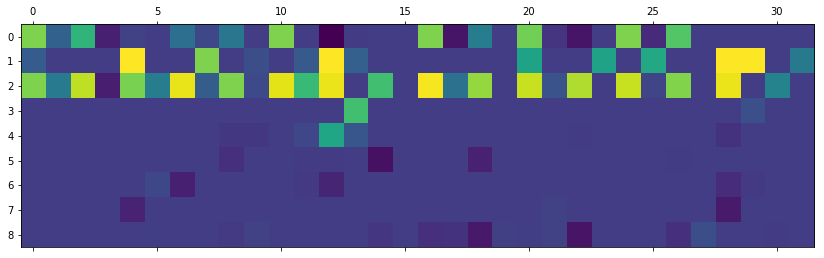



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 500)
('d_loss', 0.3124191164970398, 'a_loss', 0.9054304)
('d_accuracy', 0.4765625)
(array([[3]]), u'House')


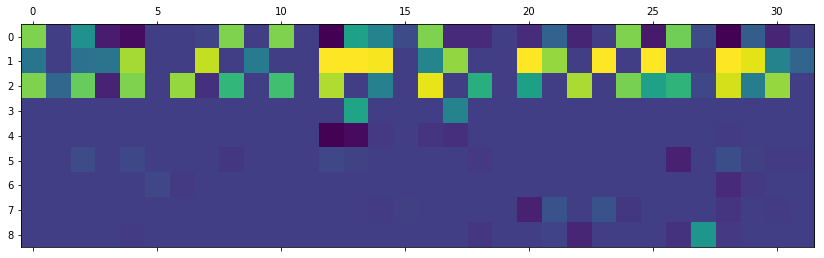



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 600)
('d_loss', 0.378409206867218, 'a_loss', 0.65502083)
('d_accuracy', 0.45703125)
(array([[4]]), u'Breakbeat')


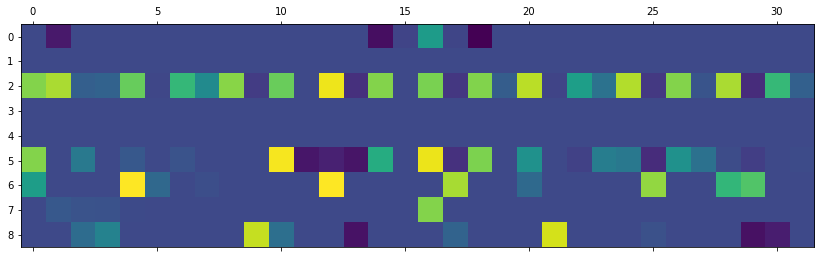



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 700)
('d_loss', 0.3385953977704048, 'a_loss', 0.9934313)
('d_accuracy', 0.484375)
(array([[3]]), u'House')


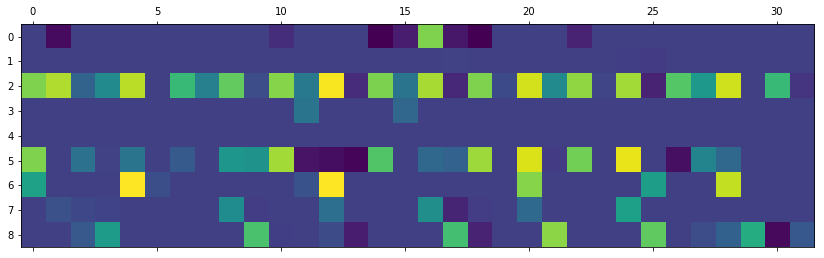



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 800)
('d_loss', 0.3805815503001213, 'a_loss', 0.98638296)
('d_accuracy', 0.45703125)
(array([[6]]), u'Techno')


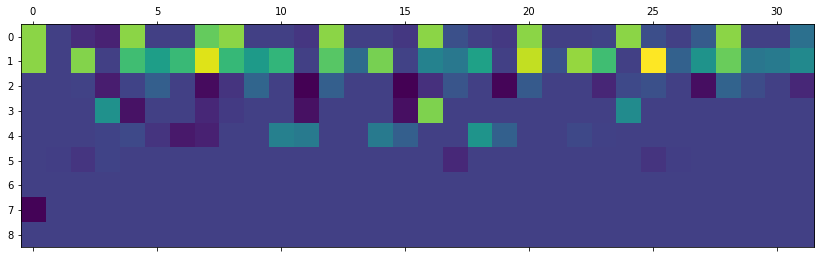



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 900)
('d_loss', 0.3390372470021248, 'a_loss', 0.84055424)
('d_accuracy', 0.4609375)
(array([[3]]), u'House')


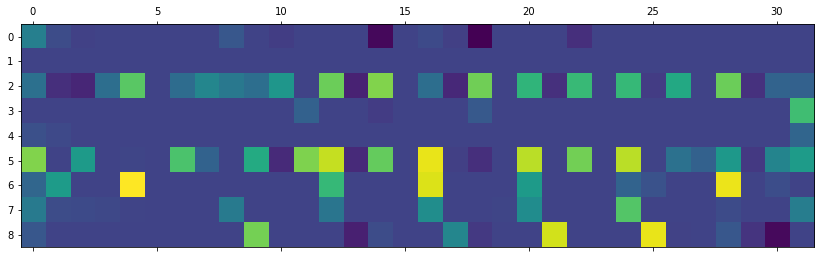



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 1000)
('d_loss', 0.3495977967977524, 'a_loss', 0.6942507)
('d_accuracy', 0.48046875)
(array([[2]]), u'Jungle')


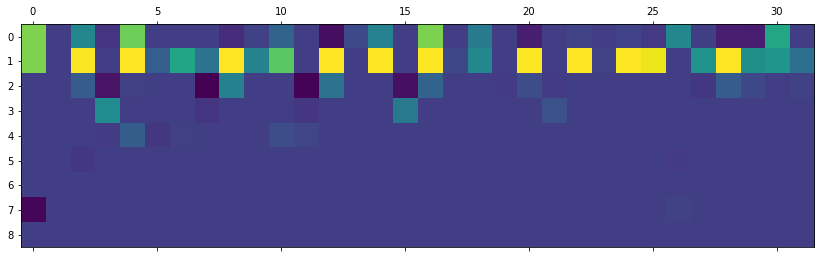



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 48, 1100)
('d_loss', 0.3283783718943596, 'a_loss', 1.0828705)
('d_accuracy', 0.484375)
(array([[5]]), u'Garage')


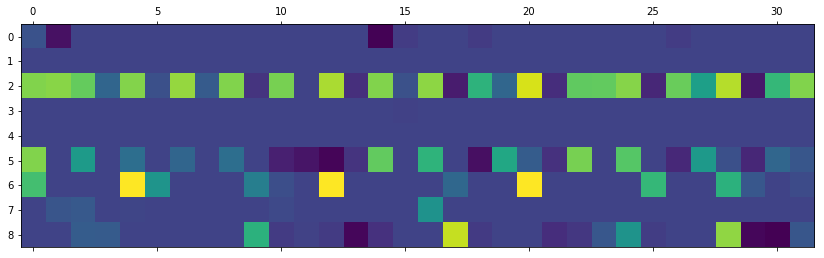



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 0)
('d_loss', 0.30189914256334305, 'a_loss', 1.0283713)
('d_accuracy', 0.48046875)
(array([[3]]), u'House')


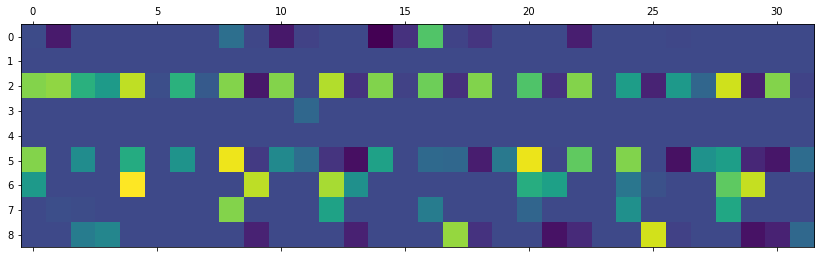



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 100)
('d_loss', 0.3263039216399193, 'a_loss', 0.7472224)
('d_accuracy', 0.47265625)
(array([[6]]), u'Techno')


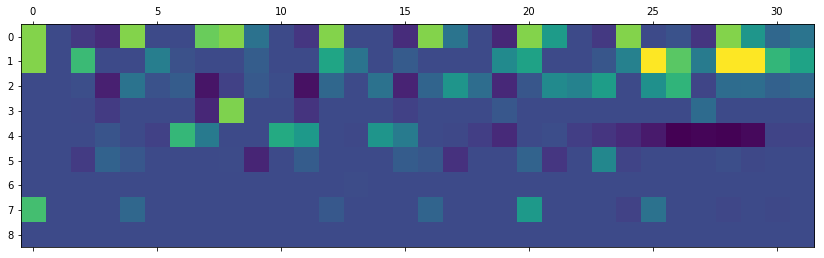



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 200)
('d_loss', 0.36365990340709686, 'a_loss', 1.0646685)
('d_accuracy', 0.45703125)
(array([[3]]), u'House')


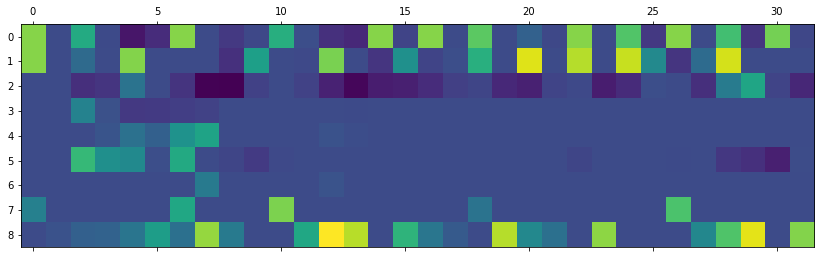



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 300)
('d_loss', 0.3099832832813263, 'a_loss', 0.9251549)
('d_accuracy', 0.46484375)
(array([[1]]), u'DnB')


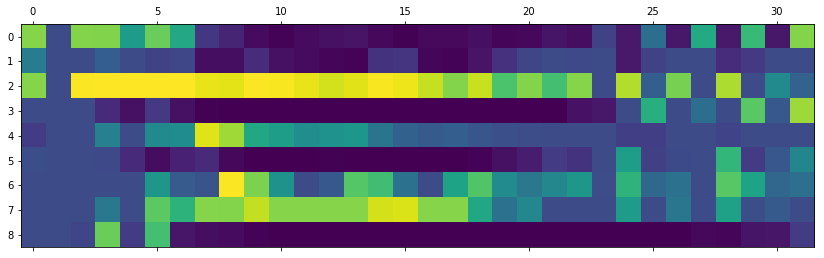



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 400)
('d_loss', 0.34808696061372757, 'a_loss', 0.90247285)
('d_accuracy', 0.47265625)
(array([[0]]), u'Old Skool')


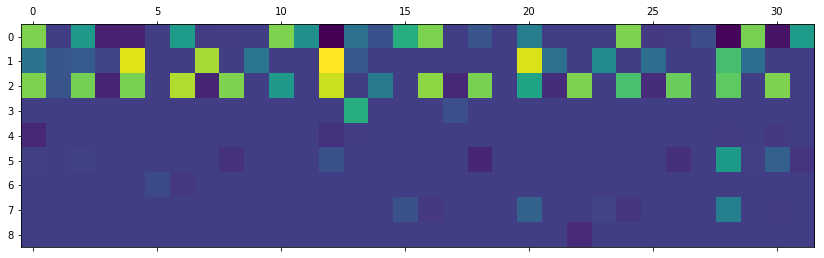



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 500)
('d_loss', 0.3280644416809082, 'a_loss', 0.79073906)
('d_accuracy', 0.46484375)
(array([[4]]), u'Breakbeat')


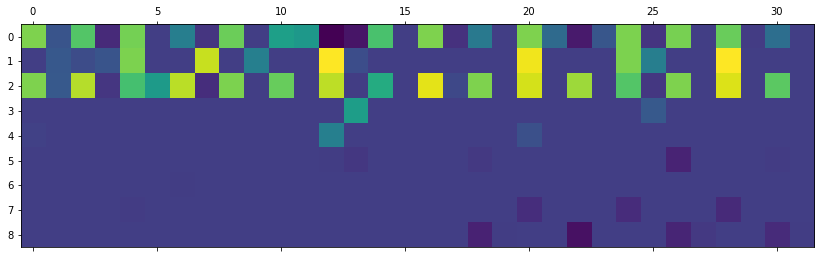



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 600)
('d_loss', 0.36945750564336777, 'a_loss', 0.8378632)
('d_accuracy', 0.45703125)
(array([[0]]), u'Old Skool')


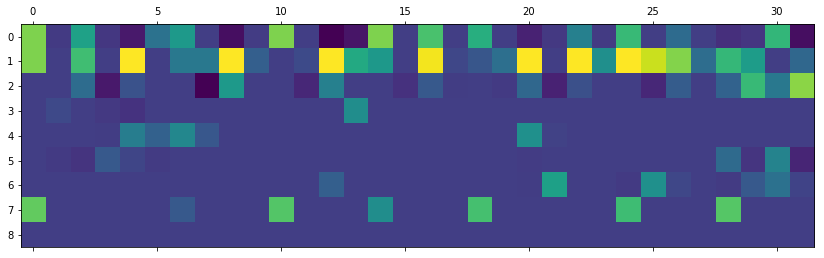



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 700)
('d_loss', 0.3304729536175728, 'a_loss', 1.1618881)
('d_accuracy', 0.453125)
(array([[4]]), u'Breakbeat')


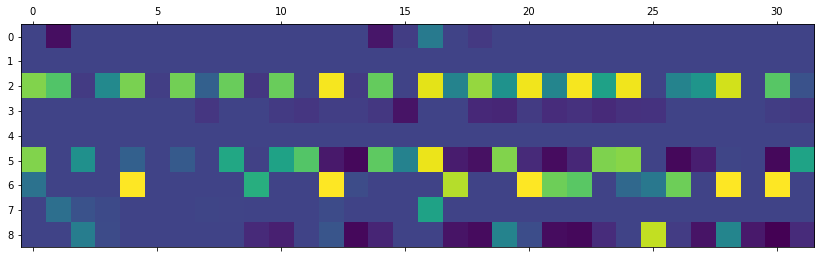



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 800)
('d_loss', 0.328741617500782, 'a_loss', 1.0558336)
('d_accuracy', 0.46484375)
(array([[5]]), u'Garage')


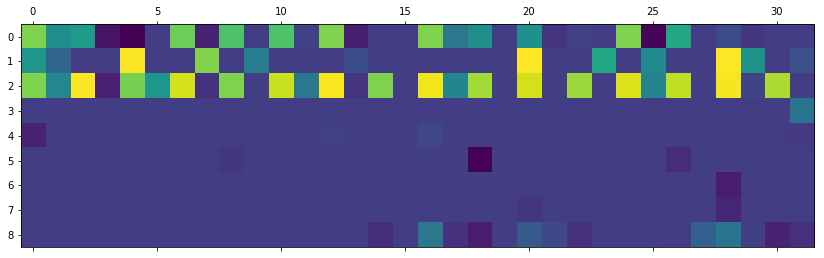



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 900)
('d_loss', 0.35423846542835236, 'a_loss', 0.5844333)
('d_accuracy', 0.4609375)
(array([[3]]), u'House')


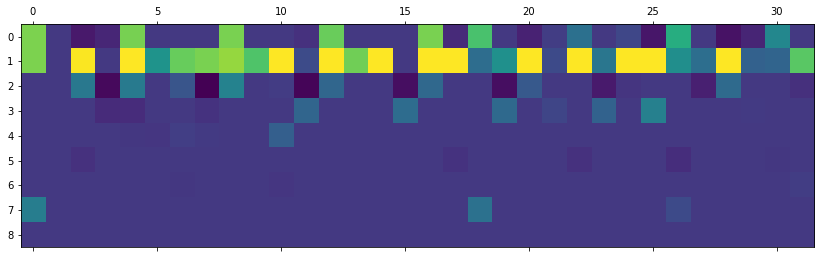



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 1000)
('d_loss', 0.3801788091659546, 'a_loss', 0.5359809)
('d_accuracy', 0.46875)
(array([[6]]), u'Techno')


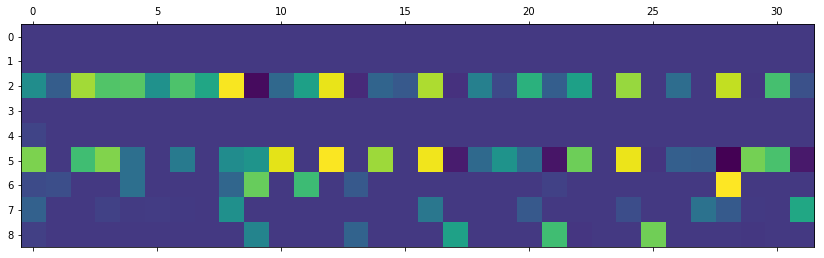



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 49, 1100)
('d_loss', 0.31732359528541565, 'a_loss', 1.329588)
('d_accuracy', 0.46875)
(array([[6]]), u'Techno')


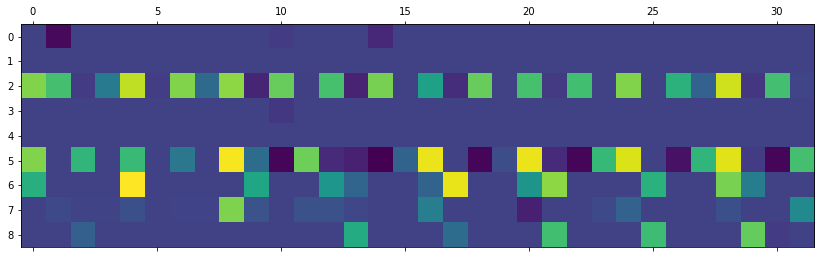



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 0)
('d_loss', 0.2884114533662796, 'a_loss', 0.6918005)
('d_accuracy', 0.4765625)
(array([[6]]), u'Techno')


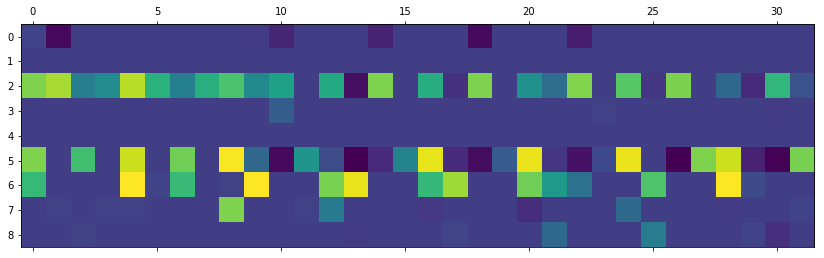



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 100)
('d_loss', 0.2908966839313507, 'a_loss', 1.0544928)
('d_accuracy', 0.48828125)
(array([[5]]), u'Garage')


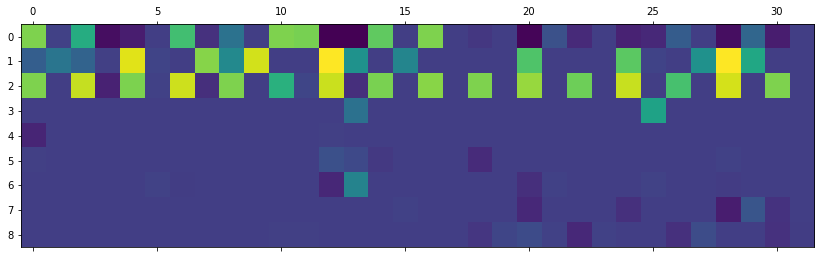



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 200)
('d_loss', 0.39324355125427246, 'a_loss', 0.77489835)
('d_accuracy', 0.453125)
(array([[5]]), u'Garage')


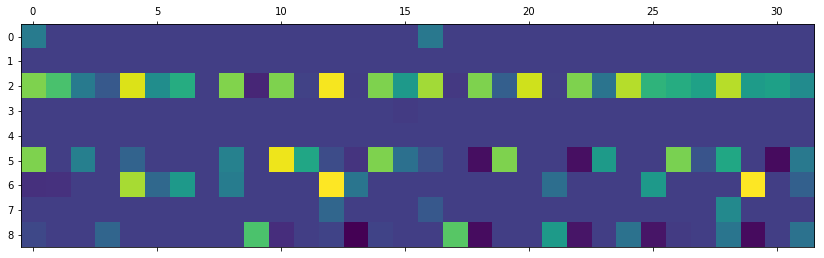



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 300)
('d_loss', 0.3604121059179306, 'a_loss', 0.62167907)
('d_accuracy', 0.47265625)
(array([[0]]), u'Old Skool')


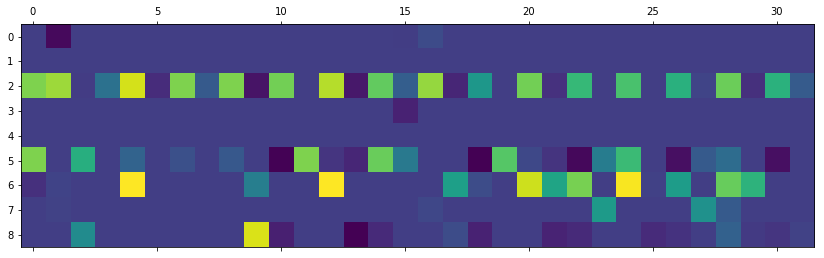



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 400)
('d_loss', 0.3452165946364403, 'a_loss', 1.2264363)
('d_accuracy', 0.46484375)
(array([[6]]), u'Techno')


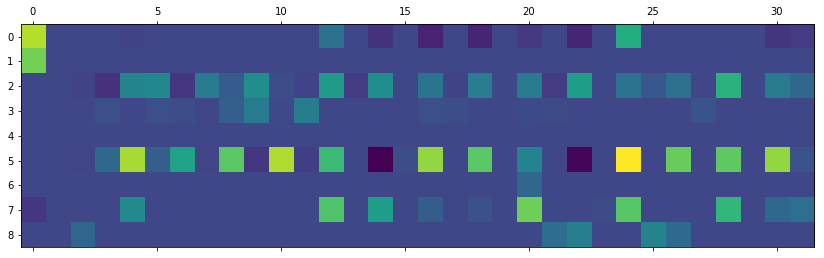



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 500)
('d_loss', 0.3260019049048424, 'a_loss', 0.9216028)
('d_accuracy', 0.453125)
(array([[6]]), u'Techno')


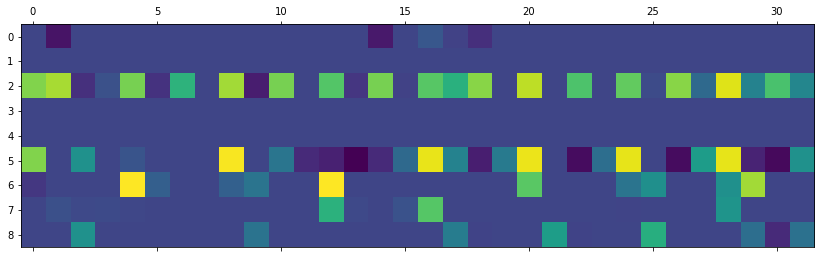



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 600)
('d_loss', 0.3646921366453171, 'a_loss', 1.1356407)
('d_accuracy', 0.44140625)
(array([[2]]), u'Jungle')


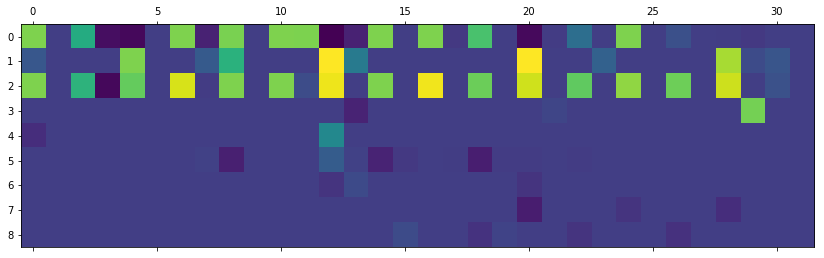



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 700)
('d_loss', 0.3365877568721771, 'a_loss', 1.0548755)
('d_accuracy', 0.46484375)
(array([[0]]), u'Old Skool')


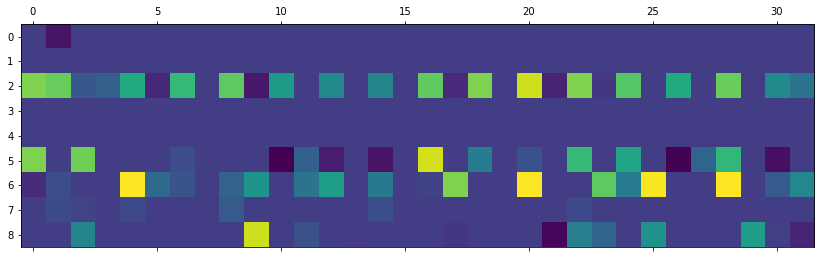



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 800)
('d_loss', 0.3279605060815811, 'a_loss', 1.5745523)
('d_accuracy', 0.47265625)
(array([[5]]), u'Garage')


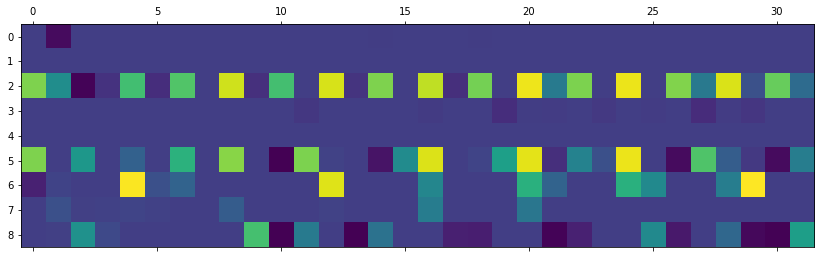



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 900)
('d_loss', 0.3234046846628189, 'a_loss', 1.1456003)
('d_accuracy', 0.46875)
(array([[3]]), u'House')


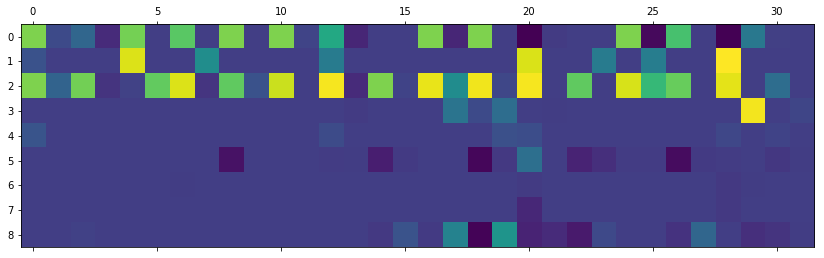



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 1000)
('d_loss', 0.3367489203810692, 'a_loss', 0.8518859)
('d_accuracy', 0.48046875)
(array([[0]]), u'Old Skool')


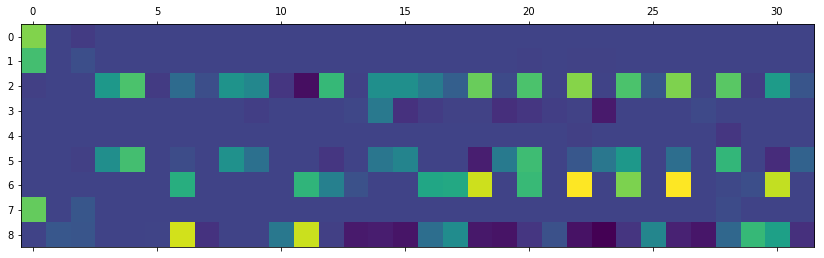



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 50, 1100)
('d_loss', 0.3683750256896019, 'a_loss', 0.9099002)
('d_accuracy', 0.45703125)
(array([[0]]), u'Old Skool')


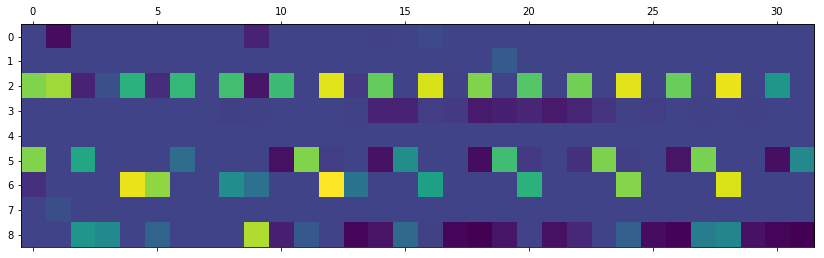



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 0)
('d_loss', 0.3638974577188492, 'a_loss', 1.3385284)
('d_accuracy', 0.44140625)
(array([[2]]), u'Jungle')


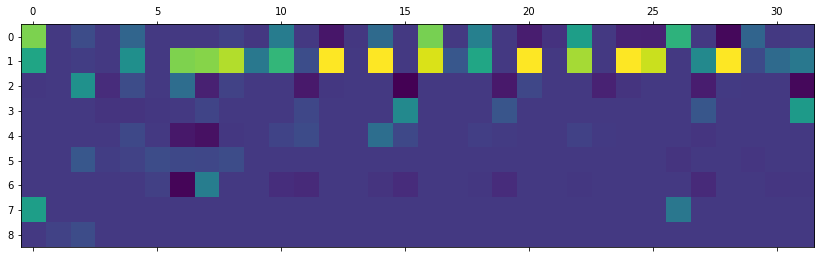



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 100)
('d_loss', 0.31427209079265594, 'a_loss', 0.65598977)
('d_accuracy', 0.48046875)
(array([[5]]), u'Garage')


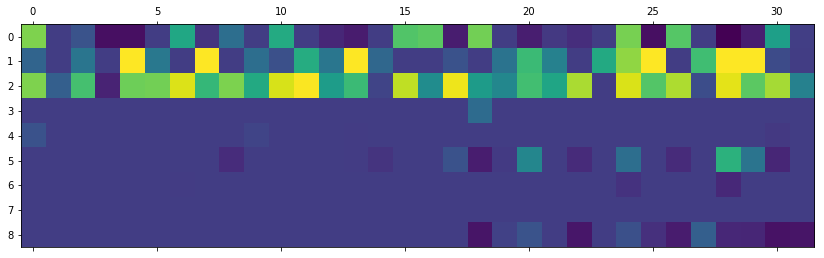



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 200)
('d_loss', 0.32307761162519455, 'a_loss', 0.9392438)
('d_accuracy', 0.46875)
(array([[6]]), u'Techno')


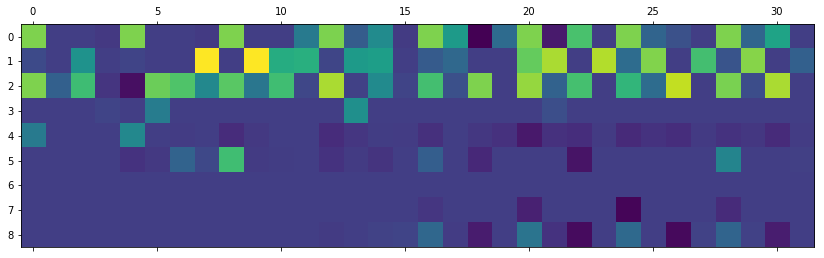



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 300)
('d_loss', 0.31520257145166397, 'a_loss', 1.4320732)
('d_accuracy', 0.46875)
(array([[0]]), u'Old Skool')


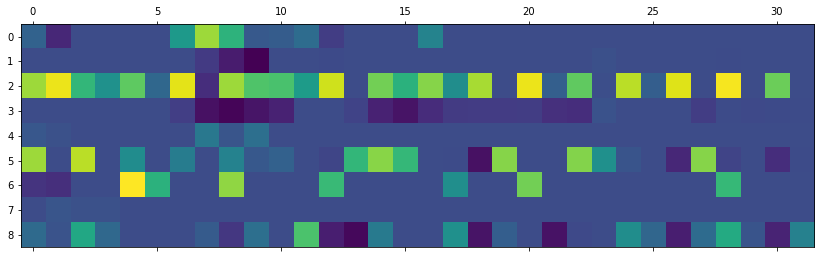



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 400)
('d_loss', 0.3466506600379944, 'a_loss', 0.99846977)
('d_accuracy', 0.44921875)
(array([[4]]), u'Breakbeat')


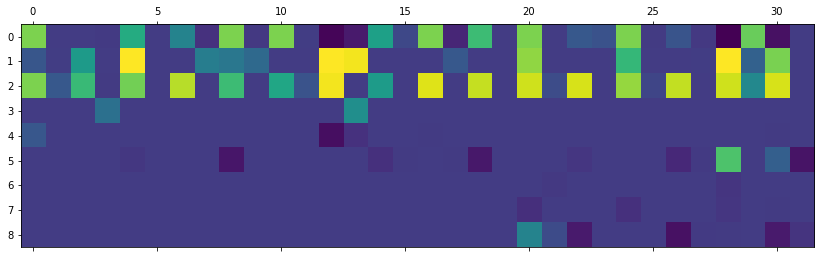



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 500)
('d_loss', 0.3263407051563263, 'a_loss', 0.53112924)
('d_accuracy', 0.47265625)
(array([[0]]), u'Old Skool')


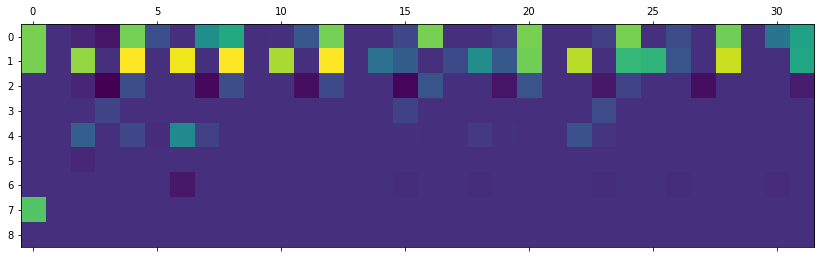



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 600)
('d_loss', 0.34356388449668884, 'a_loss', 0.97509825)
('d_accuracy', 0.4609375)
(array([[3]]), u'House')


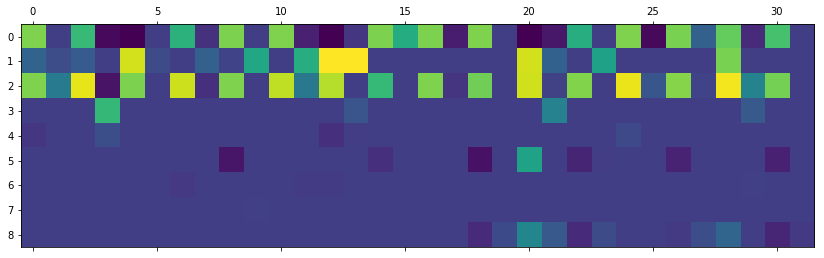



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 700)
('d_loss', 0.3306339308619499, 'a_loss', 1.2174847)
('d_accuracy', 0.4609375)
(array([[1]]), u'DnB')


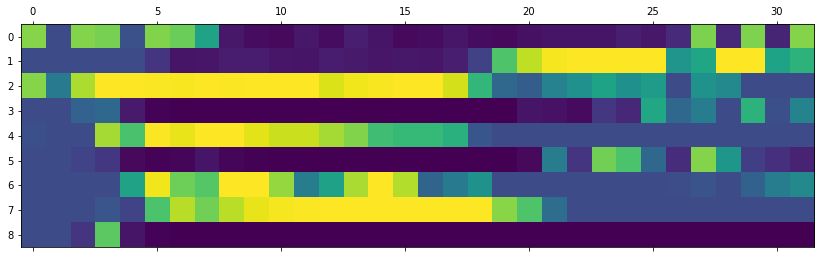



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 800)
('d_loss', 0.31915387511253357, 'a_loss', 1.0451792)
('d_accuracy', 0.47265625)
(array([[4]]), u'Breakbeat')


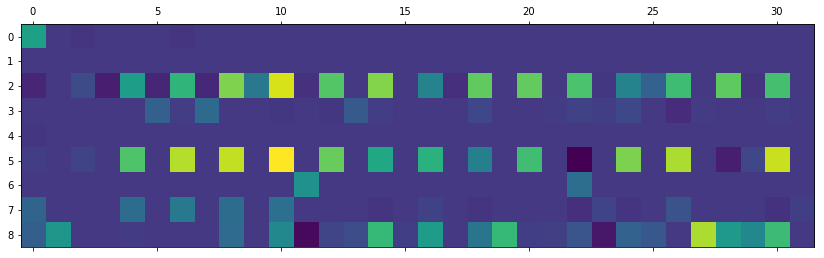



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 900)
('d_loss', 0.33668673038482666, 'a_loss', 1.1566414)
('d_accuracy', 0.4765625)
(array([[3]]), u'House')


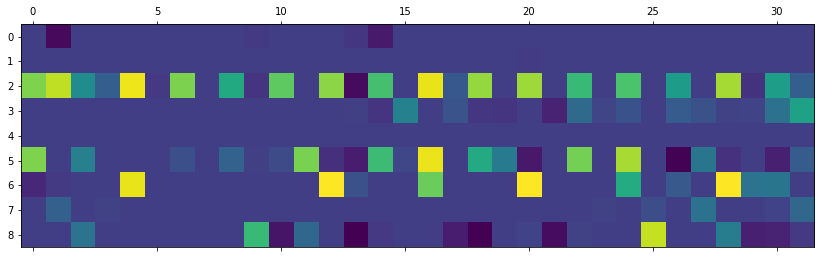



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 1000)
('d_loss', 0.2868459150195122, 'a_loss', 1.1246041)
('d_accuracy', 0.484375)
(array([[2]]), u'Jungle')


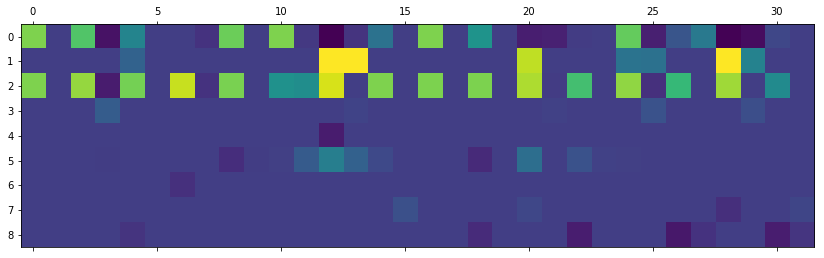



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 51, 1100)
('d_loss', 0.3117212578654289, 'a_loss', 1.1570247)
('d_accuracy', 0.4765625)
(array([[5]]), u'Garage')


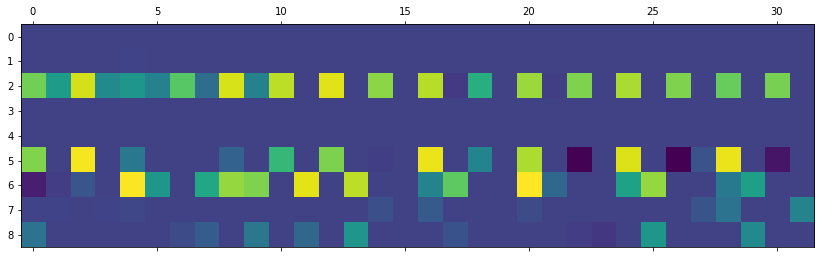



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 0)
('d_loss', 0.322430357336998, 'a_loss', 1.0852144)
('d_accuracy', 0.47265625)
(array([[5]]), u'Garage')


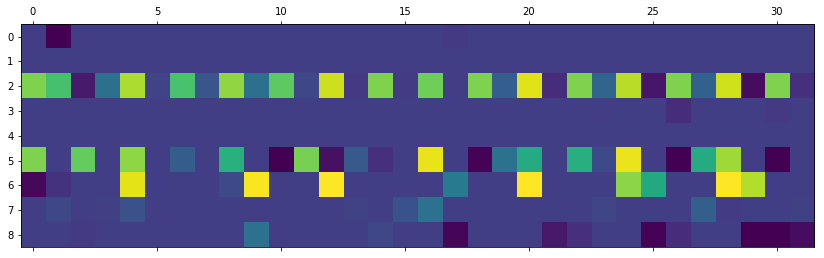



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 100)
('d_loss', 0.3370136246085167, 'a_loss', 1.1797645)
('d_accuracy', 0.45703125)
(array([[0]]), u'Old Skool')


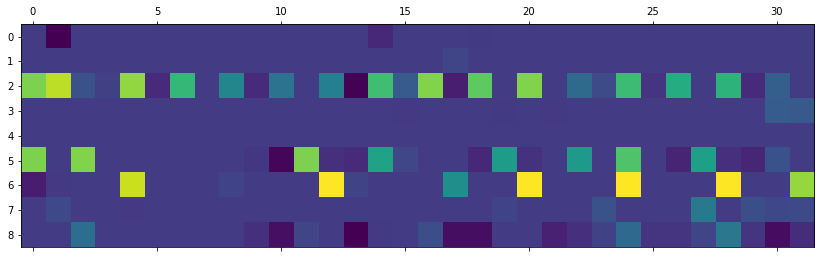



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 200)
('d_loss', 0.35705476999282837, 'a_loss', 0.921966)
('d_accuracy', 0.44921875)
(array([[0]]), u'Old Skool')


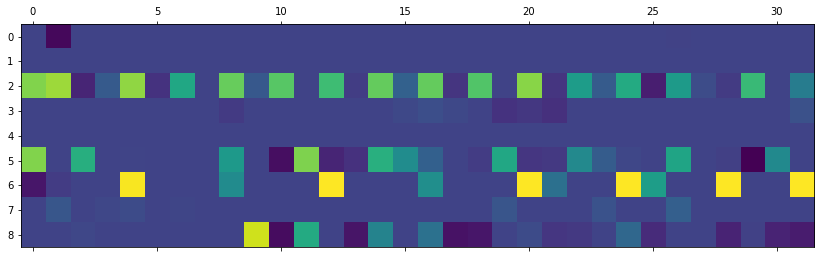



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 300)
('d_loss', 0.35145804286003113, 'a_loss', 0.9069232)
('d_accuracy', 0.48046875)
(array([[3]]), u'House')


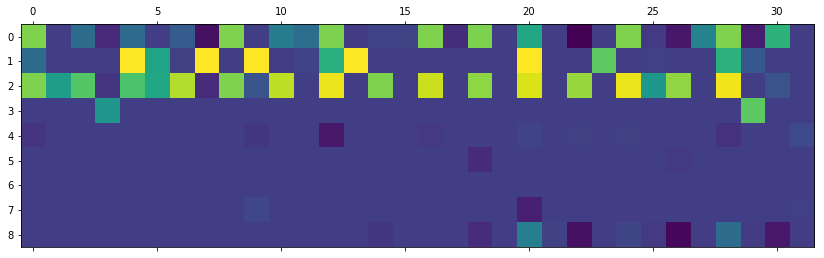



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 400)
('d_loss', 0.31705816090106964, 'a_loss', 0.7149039)
('d_accuracy', 0.46875)
(array([[1]]), u'DnB')


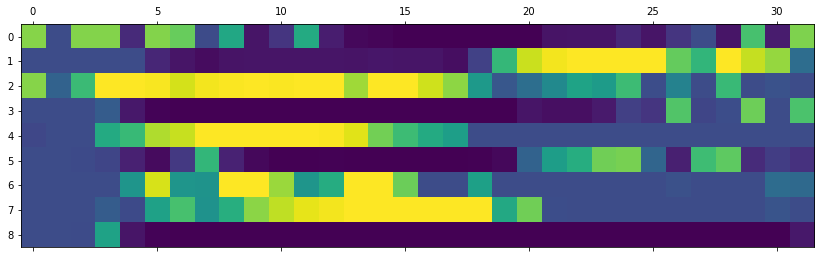



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 500)
('d_loss', 0.3067670539021492, 'a_loss', 1.0671012)
('d_accuracy', 0.4921875)
(array([[2]]), u'Jungle')


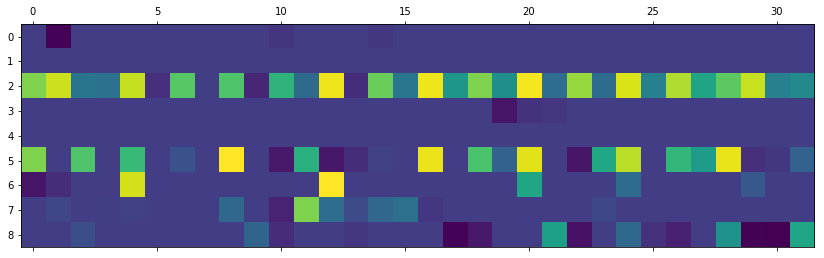



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 600)
('d_loss', 0.3178180307149887, 'a_loss', 0.84237486)
('d_accuracy', 0.45703125)
(array([[2]]), u'Jungle')


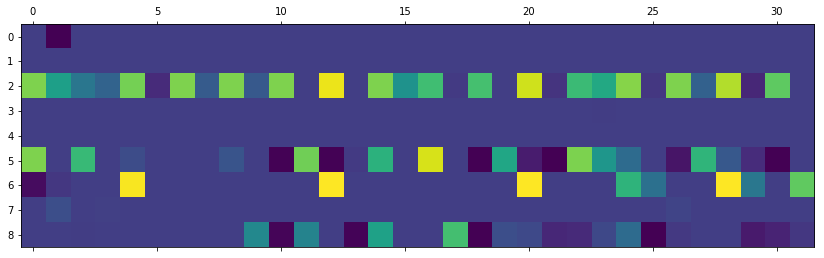



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 700)
('d_loss', 0.3450269401073456, 'a_loss', 1.01932)
('d_accuracy', 0.46875)
(array([[0]]), u'Old Skool')


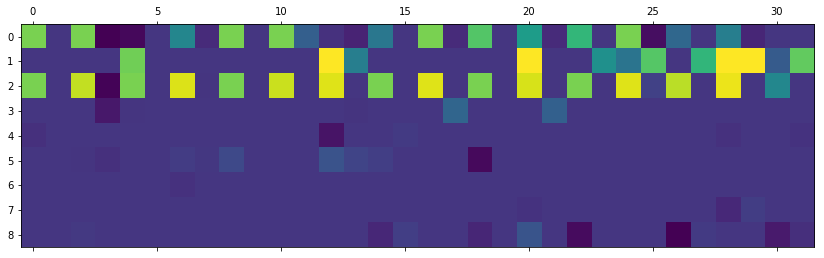



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 800)
('d_loss', 0.29362645745277405, 'a_loss', 1.0464795)
('d_accuracy', 0.484375)
(array([[4]]), u'Breakbeat')


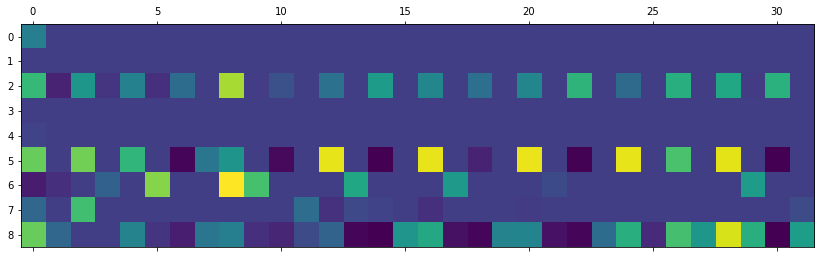



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 900)
('d_loss', 0.35418717563152313, 'a_loss', 0.9847518)
('d_accuracy', 0.46484375)
(array([[2]]), u'Jungle')


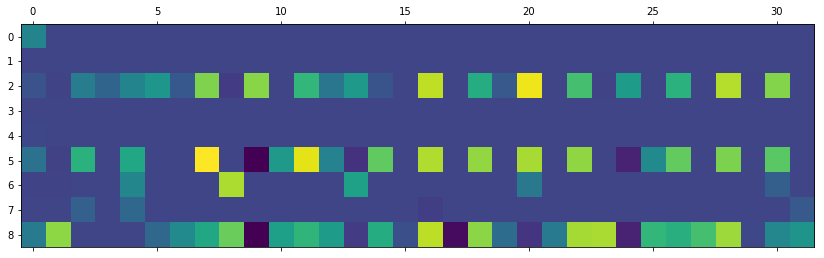



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 1000)
('d_loss', 0.32875869423151016, 'a_loss', 1.019182)
('d_accuracy', 0.47265625)
(array([[2]]), u'Jungle')


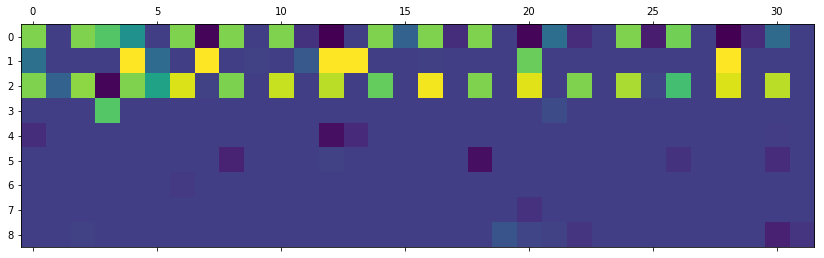



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 52, 1100)
('d_loss', 0.35090190917253494, 'a_loss', 1.5280731)
('d_accuracy', 0.4609375)
(array([[1]]), u'DnB')


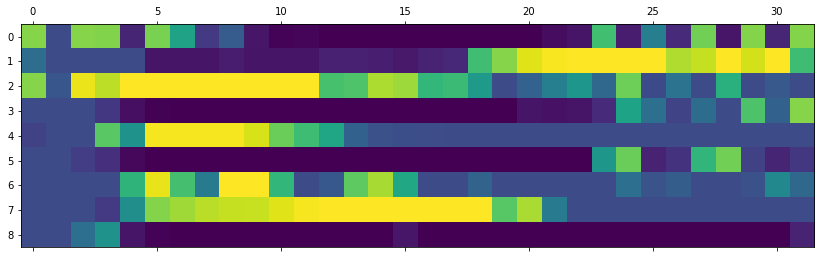



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 0)
('d_loss', 0.23204581439495087, 'a_loss', 1.9260464)
('d_accuracy', 0.49609375)
(array([[5]]), u'Garage')


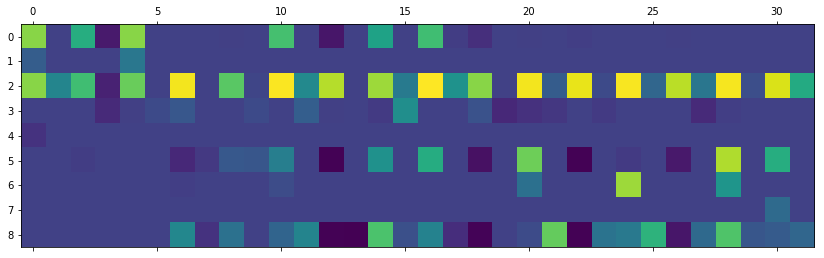



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 100)
('d_loss', 0.24619405716657639, 'a_loss', 1.5789394)
('d_accuracy', 0.5)
(array([[2]]), u'Jungle')


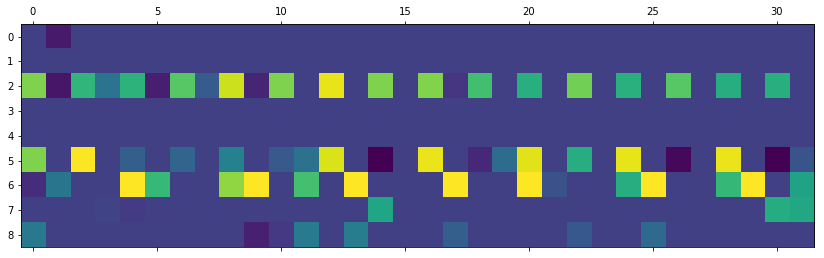



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 200)
('d_loss', 0.26965804398059845, 'a_loss', 1.4014113)
('d_accuracy', 0.49609375)
(array([[2]]), u'Jungle')


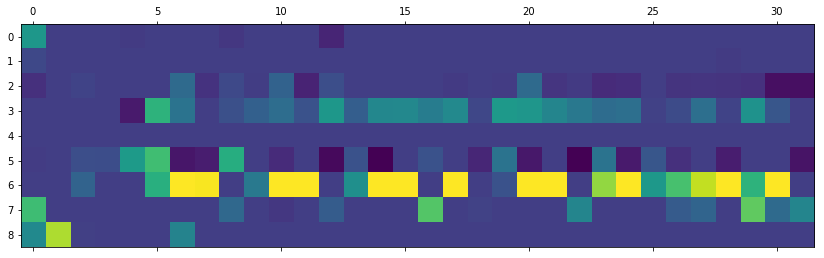



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 300)
('d_loss', 0.2960652485489845, 'a_loss', 1.1792214)
('d_accuracy', 0.5)
(array([[1]]), u'DnB')


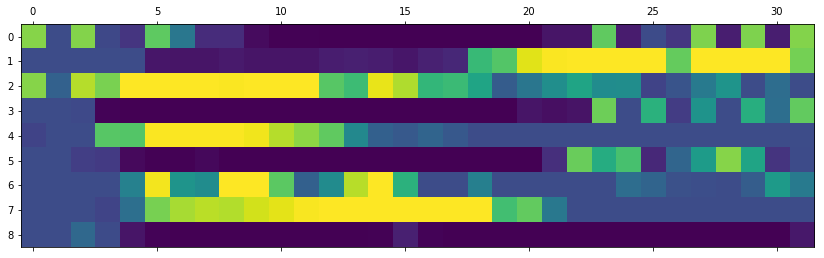



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 400)
('d_loss', 0.2590553089976311, 'a_loss', 1.7393255)
('d_accuracy', 0.5)
(array([[2]]), u'Jungle')


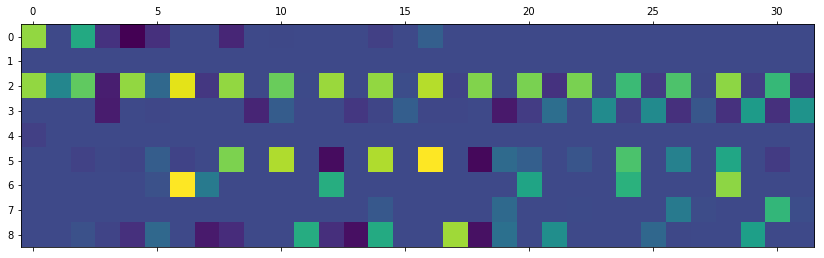



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 500)
('d_loss', 0.26594607904553413, 'a_loss', 1.4693434)
('d_accuracy', 0.48828125)
(array([[5]]), u'Garage')


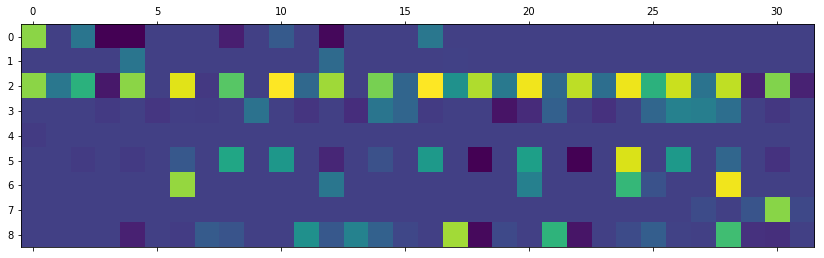



Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
Pausing D
('epoch', 53, 600)
('d_loss', 0.290937602519989, 'a_loss', 1.4563032)
('d_accuracy', 0.5)
(array([[0]]), u'Old Skool')


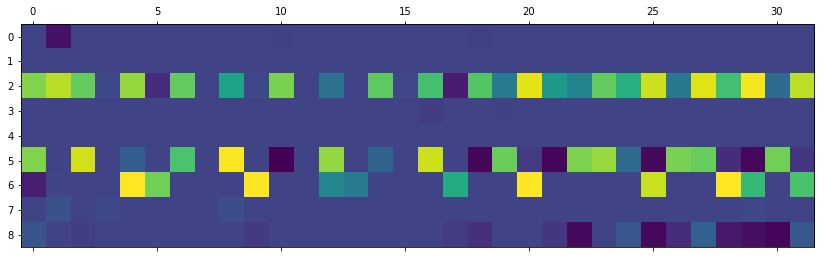



Pausing D


In [ ]:

batch_size = 32
nb_epochs = 300
nb_samples = matrices_drums.shape[0]

K_unrolled = 4
MAX_LOSS_RATIO = 3.0

# Labels for real images: all ones
real_labels = np.ones((batch_size, 1)) * 0.9

# Labels for fake images: all zeros
fake_labels = np.zeros((batch_size, 1))

train_d = True
train_g = True

for epoch in range(45, nb_epochs):
    
    nb_steps = int(nb_samples/batch_size)
    for repeat in range(nb_steps):
        
        step = nb_steps * epoch + repeat
        
        if train_d:
            
            m_d_loss = 0.0
            m_d_accuracy = 0.0
            
            for j in range(K_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_drums.shape[0], size=batch_size)
                drum_train = matrices_drums[random_indices, :, :]
                labels_traing = matrices_genres[random_indices]

                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict([noise, labels_traing])

                # training D
    #             x = np.concatenate([drum_train, drum_fake])        
    #             y = np.ones([2 * batch_size, 1])
    #             y[:batch_size, :] = 0.9 # one-sided soft labeling
    #             y[batch_size:, :] = 0 # label 0: fake 1: real
                d_loss_real = discriminator.train_on_batch([drum_train, labels_traing], real_labels)
                d_loss_fake = discriminator.train_on_batch([drum_fake,labels_traing], fake_labels)
                d_loss, d_accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

                m_d_loss += d_loss
                m_d_accuracy += d_accuracy

                # cache for later update
    #             cache_weights = discriminator.get_weights()
          
            m_d_loss /= float(K_unrolled)
            m_d_accuracy /= float(K_unrolled)
            
            # store value
            log_value("D loss", m_d_loss, step)  
            log_value("D accuracy", m_d_accuracy, step)  
        
        # training G
        
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here        

            noise = get_noise(batch_size, len_input)
            # Get a batch of random labels
            labels_random = np.random.randint(0, NB_GENRES, batch_size).reshape(-1, 1)
            a_loss = gan.train_on_batch([noise, labels_random], y)
                 
            # store value
            log_value("adversarial loss", a_loss, step)
                    
        if train_d and train_g:
            if a_loss / m_d_loss > MAX_LOSS_RATIO:
                train_d = False
                print "Pausing D"
            elif m_d_loss / a_loss > MAX_LOSS_RATIO:
                train_g = False
                print "Pausing G"
        else:
            train_d = True
            train_g = True
            
        # update layer 
#         discriminator.set_weights(cache_weights)
    
        if repeat % 100 == 0:            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "a_loss", a_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
                        
            # sample output
            noise = get_noise(1, len_input)
            labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
            drum_generated = generator.predict([noise, labels_random])
            
            print (labels_random, GENRES[int(labels_random)])
            plot_drum_matrix(drum_generated)
            
            print
            print
            
                        
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/c_generator-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
        gan.save("./tmp/c_gan-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
        discriminator.save("./tmp/c_discriminator-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))

In [ ]:
for i in range(3):
    noise = get_noise(1, len_input)
    drum_generated = generator.predict(noise)
    plot_drum_matrix(drum_generated)

# MIDI Playback

In [ ]:
# midi playback
def note_matrix_to_sequence(mat, threshold = 0.5):
    seq = []
    for row in mat[:]:
        arow = [[i, r] for i, r in enumerate(row) if r > threshold]
        seq.append(arow)
    return seq

import OSC
max_poly = 6 # maximum number of instruments played at the same time

client = OSC.OSCClient()
client.connect( ('10.0.1.14', 2014) ) 

def send_sequence_via_osc(seq):
    ## the most basic ##
    msg = OSC.OSCMessage()
    msg.setAddress("/seq")
    msg.append(max_poly * 2)
    
    for notes in seq:
        for i in range(max_poly):
            if len(notes) > i:
                msg.append([notes[i][0]+min_drum_note, notes[i][1]])
            else:
                msg.append([0, 0])
    client.send(msg)
    
def playback_seq_via_osc(mat):
    send_sequence_via_osc(note_matrix_to_sequence(mat, 0.2))

In [ ]:
import time

repeat = 1

for j in range(100):
    noise1 = get_noise(1, len_input) 
    noise2 = get_noise(1, len_input) 
    
    for i in range(repeat):
        noise = noise1 * (1.0 - i/float(repeat)) + noise2 * i/float(repeat)
        drum_generated = generator.predict(noise)
        mat = np.squeeze(drum_generated)
        playback_seq_via_osc(mat)
        time.sleep(4.0)
        clear_output(wait=True)